In [44]:
import numpy as np
import pandas as pd
import random
import copy

from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

#### Download datasets

In [45]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

In [46]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

ограничения
время работы 12 часов 720 минут
время инкассации 10 минут
 

вопросы
1) есть ли обеденный перерыв?
2) какая точка возврата?

задача 
1) объехать все точки
2) визуализация 

# №1 Объезд набора точек


In [47]:
#Количество точек
n_points = 100

In [48]:
set_points = list(set([random.randint(0, 1630) for i in range(n_points)]))

In [49]:
df = distance_matrix.iloc[set_points, set_points]

In [50]:
def create_route(df):
    return list(df.columns)


def initial_population(df, pop_size):
    return [random.sample(create_route(df), len(df.columns)) for _ in range(pop_size)]


def compute_fitness(route, df):
    return sum([df[route[i-1]][route[i]] for i in range(1, len(route))])


def selection(population, scores, elite_size):
    sorted_indices = np.argsort(scores)
    population = np.array(population)[sorted_indices]
    elite = list(population[:elite_size])
    non_elite = list(population[elite_size:])
    rest = random.choices(non_elite, k=len(population) - elite_size)
    return elite + rest


def crossover(route1, route2):
    i, j = sorted(random.sample(range(len(route1)), 2))
    child = [None]*len(route1)
    child[i:j] = route1[i:j]
    for k in range(len(route2)):
        if route2[k] not in child:
            child[child.index(None)] = route2[k]
    return child


def mutate(route, mutation_rate):
    for i in range(len(route)):
        if(random.random() < mutation_rate):
            swap_with = random.randint(0, len(route) - 1)
            route[i], route[swap_with] = route[swap_with], route[i]
    return route


def genetic_algorithm(df, pop_size, elite_size, mutation_rate, generations):
    pop = initial_population(df, pop_size)
    for i in range(generations):
        scores = [compute_fitness(route, df) for route in pop]
        pop = selection(pop, scores, elite_size)
        pop_next_gen = pop[:elite_size]
        for parent1, parent2 in zip(pop[:-1][::2], pop[1:][::2]):
            child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
            pop_next_gen += [mutate(child1, mutation_rate), mutate(child2, mutation_rate)]
        pop = pop_next_gen

    # Return the best route in the final population
    best_route_index = np.argmin([compute_fitness(route, df) for route in pop])
    return pop[best_route_index]

In [51]:
#result = genetic_algorithm(df, pop_size=100, elite_size=20, mutation_rate=0.01, generations=20)

# Visualisation

In [52]:
def get_divisors(number):
  result = {1, number}
  for divisor in range(2, number // 2  + 1):
    if number % divisor == 0:
        result.add(divisor)

  result = list(sorted(result))
  lenght_list = len(result)//2

  return result[lenght_list-1:lenght_list+1]

In [53]:
def separation_to_squares(df: pd.DataFrame, n_squares: int=4) -> dict:

    '''
        if n_squares is not power of 2, separetion will be separate for bigger different of metrics
    '''
    if n_squares < 0:
        print('Separation number is negative')
        return {}
    
    north = df.longitude.max()
    south = df.longitude.min()
    east = df.latitude.max()
    west = df.latitude.min()

    result = dict()

    '''
        search divisors for separetion of square
    '''
    if n_squares ** .5 == int(n_squares ** .5):
        multiplies = [int(sqrt(n_squares))-1]*2
    else:
        multiplies = get_divisors(n_squares)
        if multiplies[0] == 1:
            print('Primal number!')
            return result

    '''
        determine the position vaertical or horizontal
    '''
    if (north - south) > (east - west):
        position = 'vertical'
    else:
        position = 'horizontal'


    minimal = multiplies[0]+1
    maximal = multiplies[1]+1
    if multiplies[0] != multiplies[1]:
        if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal))
                result['latitude'] = list(np.linspace(east, west, maximal))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal))
                result['latitude'] = list(np.linspace(north, south, minimal))
    else:
        if position == 'vertical':
            result['longitude'] = list(np.linspace(north, south, minimal+1))
            result['latitude'] = list(np.linspace(east, west, maximal+1))
        else:
            result['longitude'] = list(np.linspace(east, west, maximal+1))
            result['latitude'] = list(np.linspace(north, south, minimal+1))

    result['longitude'] = result['longitude'][1:-1]
    result['latitude'] = result['latitude'][1:-1]
    result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

    return result


In [54]:
def visualisation_of_squares(df: pd.DataFrame, n_squares: int=4) -> dict:
    if n_squares < 0:
        print('Separation number is negative')
        return dict()
    multiplies = get_divisors(n_squares)
    if multiplies[0] == 1 and not (n_squares ** .5 == int(n_squares ** .5)):
        print('Primal number!')
        return dict()
    
    result = separation_to_squares(df, n_squares)

    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(data=df, x='latitude', y='longitude')

    for x in result['latitude']:
        axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

    for x in result['longitude']:
        axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
        
    axes.set_xlabel('latitude')
    axes.set_ylabel('longitude')

    return result

In [55]:
#visualisation_of_squares(lenght, 9)

#### Math model

In [56]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10

In [57]:
tmp = list(income.columns)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1

In [58]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.case_loop < 2, 'b', 'a')

In [59]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

#### K-Means Classtering

In [60]:
A_category = lenght.merge(model.query('category == "a"')[['number_trips']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['number_trips']], left_index=True, right_index=True, how='inner')
df = lenght.merge(model[['number_trips']], left_index=True, right_index=True, how='inner')

In [61]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [62]:
A_category = Clastering(A_category, 'number_trips', 14)
B_category = Clastering(B_category, 'number_trips', 14)
df = Clastering(df, 'number_trips', 14)

In [63]:
A_category, scce = A_category.selections()
Clastering.plot_clasters(A_category, scce['clester_count'])

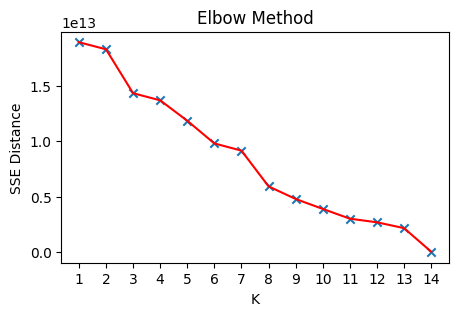

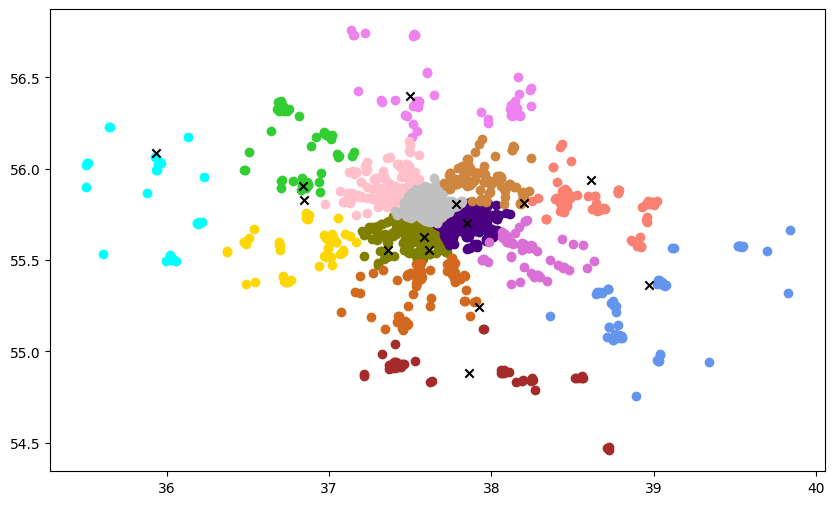

In [ ]:
B_category, scce = B_category.selections()
Clastering.plot_clasters(B_category, scce['clester_count'])

#### K-Means Classtering (added)

In [ ]:
df = df.reset_index()
model_added = copy.deepcopy(model)


def float_to_int(base: int, x: float) -> int:
    x = str(x).split('.')
    return int(x[0])*base + int(x[1])

: 

: 

In [ ]:
claster = times.merge(df[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
claster = claster.merge(df[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [ ]:
claster = claster.query('c_x==c_y')
claster

,Origin_tid,Destination_tid,Total_Time,TID_x,c_x,TID_y,c_y
0,636538,683103,15.32,636538,6,683103,6
1,636538,634763,16.20,636538,6,634763,6
2,636538,683128,16.27,636538,6,683128,6
3,636538,683789,16.77,636538,6,683789,6
6,636538,638461,18.84,636538,6,638461,6
...,...,...,...,...,...,...,...
2655215,664161,676374,12.88,664161,7,676374,7
2655218,687661,634768,15.93,687661,9,634768,9
2655227,605369,683121,15.11,605369,9,683121,9
2655231,657379,695156,21.96,657379,9,695156,9


In [ ]:

l = [[claster.query(f'c_x=={x}').Total_Time.mean(), 
      claster.query(f'c_x=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      (claster.query(f'c_x=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * claster.query(f'c_x=={x}').Total_Time.mean(),
      x] for x in range(scce['clester_count'])]
l

[[19.29335270363439, 143, 1.692607016331115, 0],
 [46.2904054054054, 75, 2.1299266290830707, 1],
 [35.54633535353535, 100, 2.1807567701555426, 2],
 [46.038191632928466, 39, 1.1015272844688406, 3],
 [55.8407701863354, 70, 2.398069885302747, 4],
 [53.5830231829574, 57, 1.8737621603856267, 5],
 [24.919364823348694, 280, 4.280627086219408, 6],
 [18.51258097165992, 209, 2.37369903256253, 7],
 [30.334732076176252, 104, 1.9354675680505096, 8],
 [19.2772692591681, 239, 2.82654438830747, 9],
 [31.824250936329587, 90, 1.75716722961329, 10],
 [53.638920454545456, 33, 1.0859413343558284, 11],
 [40.00255325814536, 57, 1.398862291849255, 12],
 [26.390712041297274, 134, 2.1695431984870153, 13]]

In [ ]:
tmp = 0
for i in range(scce['clester_count']):
    tmp += l[i][2]
print(tmp)

29.20450187517225


In [ ]:
model_added = model_added.merge(claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'c_x']].rename(columns={'c_x': 'claster'}), left_index=True, right_index=True, how='left')

In [ ]:
model_added['downtime'] = downtime * 60
model_added['Total_Time'] = model_added['Total_Time'].apply(lambda x: float_to_int(100, x))

In [ ]:
model_added['Common_Time'] = model_added[['Total_Time', 'downtime']].sum(axis=1)
model_added['Car_per_minute'] = 20000/(12*60)
model_added['Maintenance_cost_one_time'] = model_added['Common_Time']/60 * model_added['Car_per_minute']
model_added['Maintenance_cost_per_month'] = model_added['number_trips'] * model_added['Maintenance_cost_one_time']
model_added['Car_time'] = model_added['number_trips'] * model_added['Common_Time']/60

In [ ]:
model_added

,mean,std,day,day_with_limit,number_trips,limit,quantity,category,Total_Time,claster,downtime,Common_Time,Car_per_minute,Maintenance_cost_one_time,Maintenance_cost_per_month,Car_time
TID,,,,,,,,,,,,,,,,
660401,67673.913043,627294.839430,14.776743,14.000000,2.142857,14.0,1,b,476,7,600,1076,27.777778,498.148148,1067.460317,38.428571
682297,134543.478261,302806.194612,7.432542,7.432542,4.036304,7.0,1,a,1642,0,600,2242,27.777778,1037.962963,4189.534420,150.823239
689150,85195.652174,238542.655855,11.737688,11.737688,2.555870,12.0,1,b,669,0,600,1269,27.777778,587.500000,1501.573370,54.056641
634558,480119.565217,128136.675176,2.082815,2.082815,14.403587,2.0,1,a,432,13,600,1032,27.777778,477.777778,6881.713768,247.741696
688325,94543.478261,116036.126720,10.577144,10.577144,2.836304,11.0,1,b,2452,6,600,3052,27.777778,1412.962963,4007.592995,144.273348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653954,66956.521739,18215.989259,14.935065,14.000000,2.142857,14.0,1,b,2485,6,600,3085,27.777778,1428.240741,3060.515873,110.178571
657385,41456.521739,33123.615640,24.121657,14.000000,2.142857,14.0,1,b,1582,9,600,2182,27.777778,1010.185185,2164.682540,77.928571
682243,63119.565217,11180.676414,15.842948,14.000000,2.142857,14.0,1,b,2855,2,600,3455,27.777778,1599.537037,3427.579365,123.392857


In [ ]:
((model_added.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

4459210.9821859915

### Reesrt of routes

In [ ]:
income.columns = pd.to_datetime(income.columns).date
start = income.columns[0]

In [ ]:
residue = income[[start]].reset_index()
residue['Date'] = start
residue['Number_day'] = 0
residue = residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
reestr = pd.DataFrame([], columns=['Id', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day'])
reestr = pd.concat([reestr, residue]).fillna(0)

In [ ]:
if True:
    for x in list(income.columns)[1:]:

        nextday = income[[x]]
        nextday = nextday.reset_index()
        nextday['Date'] = x
        nextday = nextday.rename(columns={'TID': 'Id', x: 'Income'})

        for y in list(nextday.Id):
            reestr_tmp = reestr.query(f'Id=={y}').tail(1)
            nextday_tmp = nextday.query(f'Id=={y}')

            nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]

            nextday_tmp['Number_day'] = reestr_tmp.Number_day.values[0]+1
            nextday_tmp['Outcome'] = np.where((nextday_tmp.Number_day >= 14) | (nextday_tmp.Balance_open >= 10**6), nextday_tmp.Balance_open, 0)

            nextday_tmp['Number_day'] = np.where((nextday_tmp.Number_day.values[0] >= 14) | (nextday_tmp.Outcome !=0), 1, nextday_tmp.Number_day)
            nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

            reestr = pd.concat([reestr, nextday_tmp]).fillna(0)
    reestr.to_csv(rf'./files/reestr2.csv', index=False)

KeyboardInterrupt: 

In [ ]:
pivot = pd.read_csv(rf'./files/reestr2.csv')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/pivot.xlsx')